# Goals

* Create tiledb-soma database for the scRecounter `prod3` dataset

# Vars

In [3]:
work_dir = '/processed_datasets/scRecount/scRecounter'

# Init

In [4]:
import os
from glob import glob
import pandas as pd
import tiledbsoma
import tiledbsoma.io
import numpy as np
import plotnine as pn

In [5]:
pn.theme_set(pn.theme_bw())

In [6]:
db_uri = os.path.join(work_dir, 'tiledb-soma_prod3')
db_uri

'/processed_datasets/scRecount/scRecounter/tiledb-soma_prod3'

# Create

> Via tmux jobs to prevent disconnection

## GeneFull_Ex50pAS

```bash
./scripts/tiledb-loader.py \
  --threads 8 --skip-no-metadata --feature-type GeneFull_Ex50pAS --max-datasets 100 \
  --db-uri /processed_datasets/scRecount/scRecounter/tiledb-soma_prod3_GeneFull_Ex50pAS \
  /processed_datasets/scRecount/scRecounter/prod3 \
  > tiledb-loader_GeneFull_Ex50pAS.log 2>&1
```


## GeneFull

First 100 datasets:

```bash
./scripts/tiledb-loader.py \
  --threads 8 --skip-no-metadata --feature-type GeneFull --max-datasets 100 \
  --db-uri /processed_datasets/scRecount/scRecounter/tiledb-soma_prod3_GeneFull \
  /processed_datasets/scRecount/scRecounter/prod3
```


# Summary

## GeneFull_Ex50pAS

In [7]:
db_uri = "/processed_datasets/scRecount/scRecounter/tiledb-soma_prod3_GeneFull_Ex50pAS"

In [29]:
# get obs metadata overview
with tiledbsoma.open(db_uri) as exp:
    print(exp.obs.schema)

soma_joinid: int64 not null
obs_id: large_string
gene_count: int64
umi_count: float
barcode: large_string
SRX_accession: large_string
lib_prep: large_string
tech_10x: large_string
organism: large_string
tissue: large_string
disease: large_string
purturbation: large_string
cell_line: large_string
czi_collection_id: large_string
czi_collection_name: large_string


### Obs count

In [18]:
# total observations
with tiledbsoma.open(db_uri) as exp:
    print(
        exp.obs.read(column_names=["obs_id"])
        .concat()
        .group_by([])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )

   count_all
0     242840


In [19]:
# obs per SRX
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read()
        .concat()
        .group_by(['SRX_accession'])
        .aggregate([
            ([], 'count_all'),
        ])
        .sort_by([("count_all", "descending")])
        .to_pandas()
    )
print(df.shape)
df.tail()

(32, 2)


,SRX_accession,count_all
27,SRX23508713,2743
28,SRX22127249,2579
29,SRX23508714,1323
30,SRX23261461,912
31,SRX23508715,758


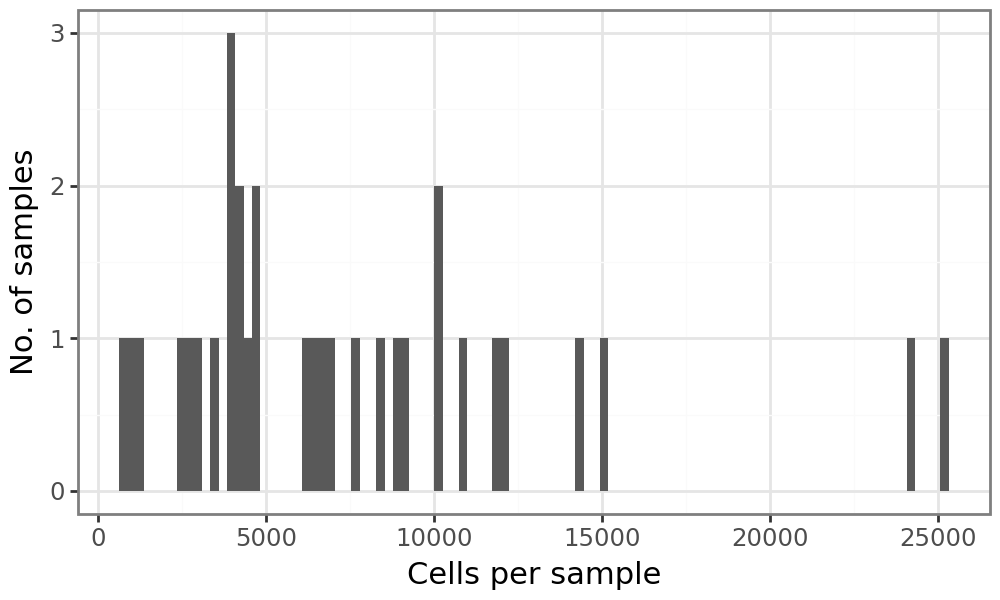

In [20]:
# plot cells per SRX
p = (
    pn.ggplot(df, pn.aes(x="count_all")) + 
    pn.geom_histogram(bins=100) +
    pn.labs(x="Cells per sample", y="No. of samples") +
    pn.theme(figure_size=(5,3))
    )
p

In [34]:
# obs per SRX
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read()
        .concat()
        .group_by(["tech_10x"])
        .aggregate([
            ([], 'count_all'),
        ])
        .sort_by([("count_all", "descending")])
        .to_pandas()
    )
print(df.shape)
df.tail()

(6, 2)


,tech_10x,count_all
1,5_prime_gex,83551
2,vdj,6302
3,other,4213
4,feature_barcoding,3538
5,multiome,1925


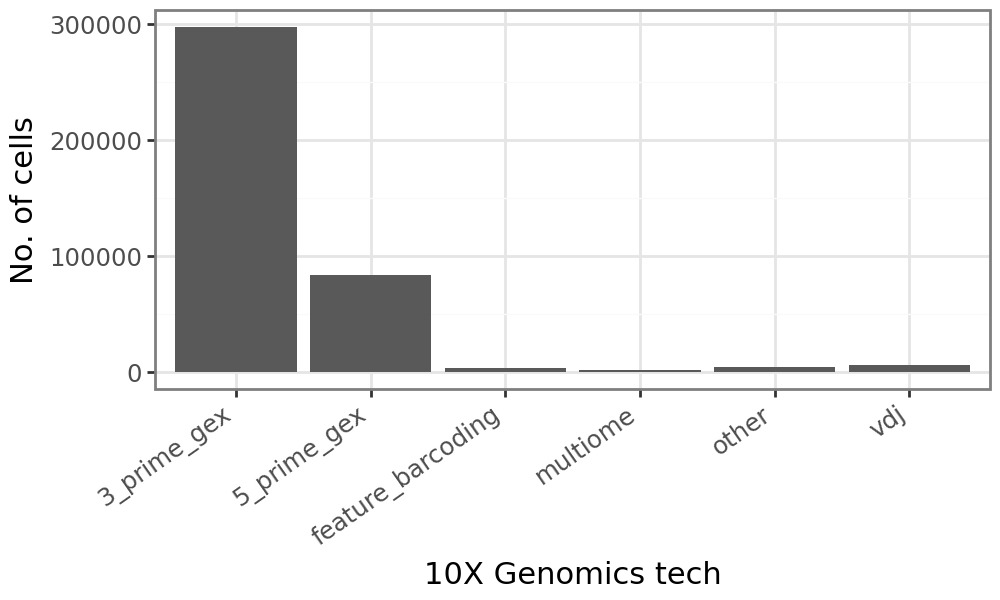

In [ ]:
# plot cells per SRX and tech
p = (
    pn.ggplot(df, pn.aes(x="tech_10x", y="count_all")) + 
    pn.geom_col() +
    pn.labs(x="10X Genomics tech", y="No. of cells") +
    pn.theme(
        figure_size=(5,3),
        axis_text_x=pn.element_text(rotation=35, hjust=1)
    ))
p

### Gene/UMI counts

In [21]:
# gene and umi counts
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["SRX_accession", "gene_count", "umi_count"])
        .concat()
        .sort_by([("gene_count", "descending")])
        .to_pandas()
    )
df

,SRX_accession,gene_count,umi_count
0,SRX23508713,13602,242495.0
1,SRX20179995,13490,406991.0
2,SRX20179995,13024,295188.0
3,SRX23508715,12884,139157.0
4,SRX23508715,12875,114757.0
...,...,...,...
253659,SRX21831069,18,871.0
253660,SRX17300900,17,149.0
253661,SRX21831069,16,1115.0
253662,SRX21831069,15,733.0


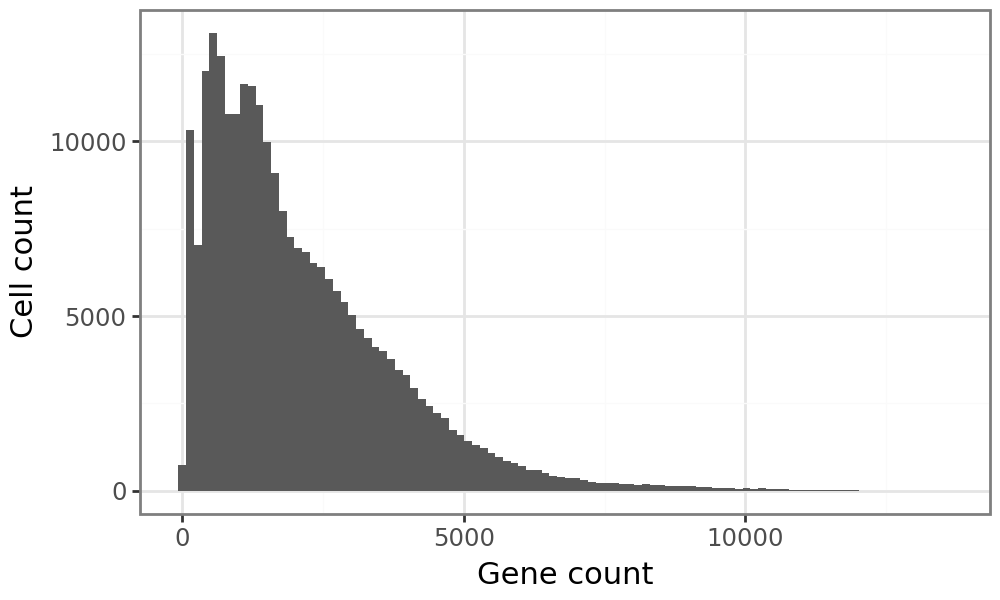

In [ ]:
# plot genes per cell
p = (
    pn.ggplot(df, pn.aes(x="gene_count")) + 
    pn.geom_histogram(bins=100) +
    pn.labs(x="Gene count", y="Cell count") +
    pn.theme(figure_size=(5,3))
    )
p

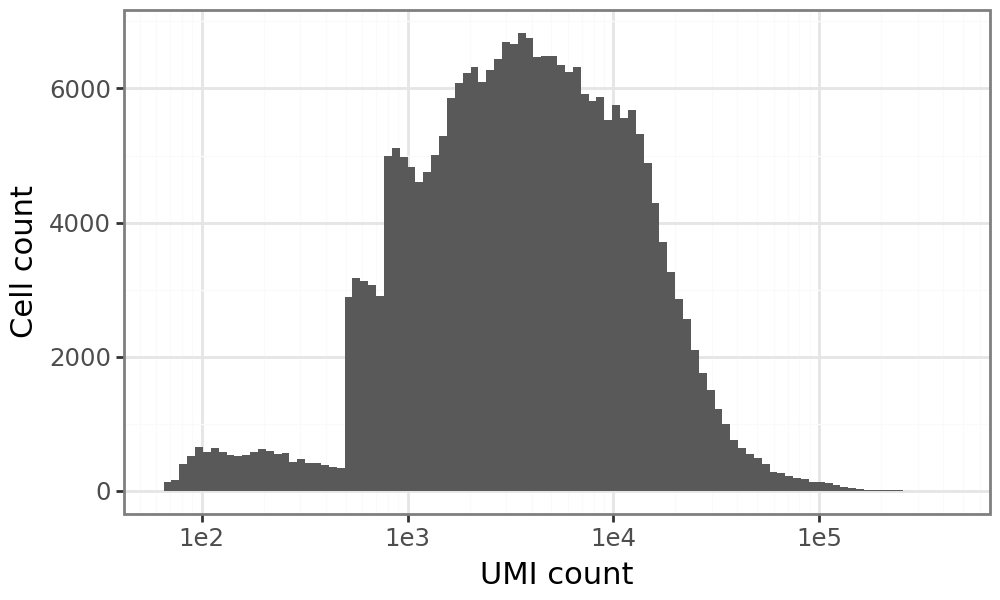

In [27]:
# plot UMIs per cell
p = (
    pn.ggplot(df, pn.aes(x="umi_count")) + 
    pn.geom_histogram(bins=100) +
    pn.scale_x_log10() +
    pn.labs(x="UMI count", y="Cell count") +
    pn.theme(figure_size=(5,3))
    )
p

# Sandbox

In [23]:
import scanpy as sc

In [58]:
p = "/processed_datasets/scRecount/scRecounter/prod3/SCRECOUNTER_2025-01-16_14-55-07/STAR/SRX23665550/GeneFull/filtered/"
adata = sc.read_10x_mtx(p)
adata

AnnData object with n_obs × n_vars = 14844 × 32285
    var: 'gene_ids', 'feature_types'

In [60]:
# get obs_id
adata.obs.index

Index(['AAACCCAAGAATTGTG', 'AAACCCAAGCCTTTCC', 'AAACCCAAGCGTTCCG',
       'AAACCCAAGGTATAGT', 'AAACCCAAGTTTCGGT', 'AAACCCACAAAGCACG',
       'AAACCCACAAATACAG', 'AAACCCACACATATGC', 'AAACCCACACCCAAGC',
       'AAACCCACACCTATCC',
       ...
       'TTTGGTTTCTATCGTT', 'TTTGTTGAGCCTGGAA', 'TTTGTTGAGGAGGGTG',
       'TTTGTTGAGGGCTGAT', 'TTTGTTGAGTATGAAC', 'TTTGTTGCAACCCTCT',
       'TTTGTTGCACATAGCT', 'TTTGTTGCACGTTCGG', 'TTTGTTGCACTCCCTA',
       'TTTGTTGGTCTACATG'],
      dtype='object', length=14844)

In [28]:
#(adata.X > 0).sum(axis=1).A1
adata.X.sum(axis=1).A1

array([ 8611.,  2874.,  4688., ..., 14166.,  6238.,  5111.], dtype=float32)

In [31]:
(adata.X > 0).shape

(14844, 32285)